This notebook creates the craving simulation and predicts its craving via Decision Tree, SVM and Logistic Regression

In [679]:
import hashlib 
import time  
import random  
import math  
import pandas as pd  
import numpy as np

## headings : column names 

In [680]:
headings = ["UserID", "Gender", "Age", "SocialType", "Fitness","Emotionality","Triggers","Emotion", "Date", "Time", "Weekday", "Asleep", "Occupied",
            "SocialCompany", "Location", "Craving"]


## generate data

In [740]:
occupation_types = [8, 4, 0]  # stands for hours: fulltime, halftime, none
genders = ["male", "female"]
day_locations = ["home", "store", "workout"]
night_locations = ["restaurant", "party", "home"] #restaurant stands for restaurant or bar
social_companies = ["alone", "friends", "family", "partner"]
emotions = ["neutral","anxious","sad","stressed","tired","frustrated","happy","proud","bored"]

variables = {
                "Drinking alone",
                "Drinking with two or more friends",
                "Drinking with a friend",
                "Drinking at a party",
                "Drinking in a restaurant",
                "Drinking in a bar",
                "Drinking in a pub",
                "Drinking at home",
                "Drinking at night",
                "Drinking during the afternoon",
                "Drinking on a Friday",
                "Drinking on a Saturday",
                "Drinking while anxious/tense",
                "Drinking while sad",
                "Drinking while stressed",
                "Drinking while frustrated",
                "Drinking beer",
                "Drinking red wine",
                "Drinking whisky"
        }


In [741]:
craving_dist = pd.read_csv('Data/ghita_craving_data.csv')
craving_dist['attribute'] = ['alone', 'friends', '1 friend', 'party', 'restaurant', 'bar', 'pub', 'home','night','afternoon','Friday', 'Saturday','anxious', 'sad', 'stressed', 'frustrated','beer','wine','whisky']
craving_dist

,trigger,m_no_c_max,m_c_min,m_no_c_min,m_c_max,m_c_med,f_no_c_max,f_c_min,f_no_c_min,f_c_max,f_c_med,attribute
0,Drinking alone,0.55,0.45,0.33,0.67,0.56,0.27,0.73,0.00,1.00,0.87,alone
1,Drinking with two or more friends,0.43,0.57,0.15,0.85,0.71,0.34,0.66,0.01,0.99,0.82,friends
2,Drinking with a friend,0.42,0.58,0.16,0.84,0.71,0.43,0.57,0.15,0.85,0.71,1 friend
3,Drinking at a party,0.35,0.65,0.03,0.97,0.81,0.36,0.64,0.04,0.96,0.80,party
4,Drinking in a restaurant,0.35,0.65,0.03,0.97,0.81,0.29,0.71,0.00,1.00,0.86,restaurant
5,Drinking in a bar,0.46,0.54,0.18,0.82,0.68,0.40,0.60,0.11,0.89,0.74,bar
6,Drinking in a pub,0.66,0.34,0.50,0.50,0.42,0.57,0.43,0.46,0.54,0.48,pub
7,Drinking at home,0.48,0.52,0.24,0.76,0.64,0.42,0.58,0.13,0.87,0.73,home
8,Drinking at night,0.47,0.53,0.20,0.80,0.66,0.37,0.63,0.09,0.91,0.77,night
9,Drinking during the afternoon,0.47,0.53,0.21,0.79,0.66,0.52,0.48,0.28,0.72,0.60,afternoon


In [779]:
def set_sleep(actual_bedtime, startdate, sleep_length):
    sleep = 0
    if (startdate.hour - actual_bedtime) % 24 <= sleep_length:
        sleep = 1
    return sleep


def set_occupation(startdate, occupation_type, actual_bedtime, sleep_length):
    occupation = 0
    if startdate.weekday() < 5 and (startdate.hour - (actual_bedtime+sleep_length+2) % 24) % 24 < occupation_type:
        occupation = 1
    return occupation


def set_social_company(occupation, sleep, startdate, social_type, fitness, activity, weekend):
    if occupation == 1:
        social_company = "colleagues"
        location = "occupation"
    elif sleep == 1:
        social_company = "alone"
        location = "home"
    else:
        if activity[0] in ["party","restaurant"]:
            return activity
        sociability = abs(social_type/20)
        if weekend:
            sociability = sociability * 2
        if sociability > 0.6:
                sociability = 0.6
        social_company = np.random.choice(["friends","family","partner","alone"], p=[sociability/2,sociability/2,(1-sociability)/2, (1-sociability)/2])
        if (startdate.hour > 19 or startdate.hour < 3):
            going_out = abs(sociability/12)
            if going_out > 0.8:
                going_out = 0.8
            location = np.random.choice(night_locations, p=[going_out/2,going_out/2,1-going_out])
        else:
            fitness_hourly = abs(fitness/48)
            if fitness_hourly > 0.3:
                fitness_hourly = 0.3
            rest_p = 1-fitness_hourly
            location = np.random.choice(day_locations, p=[0.95*rest_p,0.05*rest_p,fitness_hourly])#["home", "store", "sportive activity"]
    return (location, social_company)

def set_emotion(sleep, sleep_length, emotionality, activity, prev_activity):
    if sleep == 1:
        emotion = "neutral"
    else:
        emotion_dict = { i : 1 for i in emotions }
        emotion_dict["neutral"] +=8
        if(sleep_length < 7):
            emotion_dict["tired"] += 2
        if(activity[0] == "workout" or prev_activity[0] =="workout"):
            emotion_dict["neutral"] += 2
            emotion_dict["happy"] += 2
            emotion_dict["proud"] += 2
            emotion_dict["bored"] -= 1
        if(activity == ("home","alone")):
            emotion_dict["bored"] += 2
        if(prev_activity[0] == "occupation" or activity[0] == "occupation"):
            emotion_dict["stressed"] += 2
        emotional = abs(emotionality)/5
        for e in ["anxious","sad","stressed","frustrated","happy","proud"]:
            emotion_dict[e] = emotion_dict[e]*emotional
        emotion_sum = sum(emotion_dict.values())
        for e, p in emotion_dict.items():
            emotion_dict[e] = emotion_dict[e]/emotion_sum
        emotion = np.random.choice(emotions, p=list(emotion_dict.values())) #emotions = ["neutral","anxious","sad","stressed","tired","frustrated","happy","proud","bored"]
    return emotion

def set_triggers(age, gender, occupation_type, social_type, emotionality, num_triggers):
    if age > 45:
        num_triggers -= 1
    ghita_triggers = craving_dist["attribute"]
    trigger_dict_male = { i : np.random.choice(2,p = [1-craving_dist.loc[craving_dist['attribute'] == i, 'm_c_med'].values[0],craving_dist.loc[craving_dist['attribute'] == i, 'm_c_med'].values[0]]) for i in craving_dist["attribute"] }
    trigger_dict_female = { i : np.random.choice(2,p=[1-craving_dist.loc[craving_dist['attribute'] == i, 'm_c_med'].values[0],craving_dist.loc[craving_dist['attribute'] == i, 'm_c_med'].values[0]]) for i in craving_dist["attribute"] }
  
    no_triggers = set(["workout", "neutral", "happy", "home", "occupation"])
    possible_triggers = set(["Friday", "Saturday", "night", "afternoon"] + social_companies + emotions+  day_locations + night_locations).difference(no_triggers)
    for t in possible_triggers: 
        if not t in list(craving_dist['attribute']):
            p = 0.4
            trigger_dict_female[t] = np.random.choice(2,p = [1-p, p])
            trigger_dict_male[t] = np.random.choice(2,p = [1-p, p])

    items = trigger_dict_female.items()
    if gender == "male":
        items = trigger_dict_male.items()
    items = [k for k,v in items if v == 1 and k in possible_triggers]
    if len(items)>num_triggers:
        return np.random.choice(items, size = num_triggers,replace=False)
    return items

def predict_cravings(startdate, occupation, sleep, location, social_company, emotion, triggers, noise):
    if sleep:
        return 0
    status = [occupation, location, social_company,emotion]
    if startdate.weekday() == 4:
        status.append("Friday")
    if startdate.weekday() == 5:
        status.append("Saturday")
    if startdate.hour >= 19:
        status.append("night")
    if startdate.hour < 19 and startdate.hour > 13:
        status.append("afternoon")
    p = 1-noise**len(set(triggers).intersection(set(status)))
    return np.random.choice(2,p = [1-p, p])


In [757]:
# https://www.discoveringdata.org/index.php/2020/09/06/generating-data-with-jupyter-notebook/
import datetime
import numpy as np

def generate_data(number_users = 1, number_training_days = 15, number_triggers = 3, noise = 0.0):
    number_days = math.ceil((5/4)*number_training_days)
    accounts = []
    startdate = datetime.datetime(2022, 1, 1, 0, 0)
    #generate users
    for user in range(number_users):
        userID = hashlib.md5(str(time.time()).encode()).hexdigest()
        gender = random.choice(genders)
        age = random.randint(18, 65)
        social_type = int(np.random.normal(size = 1, loc = 5.5, scale = 1.5)[0])
        fitness = int(np.random.normal(size = 1, loc = 5.5, scale = 1.5)[0])
        bedtime_base = (23 + random.randint(-1, 1)) % 24
        occupation_type = np.random.choice(occupation_types,p=[0.55,0.25,0.2])
        average_sleep = random.randint(7, 8)
        emotionality = int(np.random.normal(size = 1, loc = 5.5, scale = 1.5)[0])
        activity = ("home","alone")
        triggers = set_triggers(age, gender, occupation_type, social_type, emotionality, number_triggers)
        #generate days for the users
        for day in range(number_days):
            weekend = False
            actual_bedtime = (bedtime_base + random.randint(-1, 1)) % 24
            sleep_length = average_sleep + random.randint(-1, 1)
            if(startdate.weekday() > 4):
                weekend = True
                actual_bedtime += random.randint(0, 2)
                sleep_length += 1
            #generate hours for each day 
            for hour in range(24):
                account = []
                sleep = set_sleep(actual_bedtime, startdate, sleep_length)
                occupation = set_occupation(
                    startdate, occupation_type, actual_bedtime, sleep_length)
                prev_activity = activity
                activity = set_social_company(occupation, sleep, startdate, social_type, fitness, prev_activity,weekend)
                location = activity[0]
                social_company = activity[1]
                emotion = set_emotion(sleep, sleep_length, emotionality, activity, prev_activity)
                craving = predict_cravings(startdate, occupation, sleep, location, social_company, emotion, triggers, noise)
                account.extend([userID, gender, age, social_type, fitness, emotionality,triggers, emotion, startdate, startdate.hour,
                                startdate.weekday(), sleep, occupation, social_company, location, craving])
                accounts.append(account)
                startdate += datetime.timedelta(hours=1)
    return pd.DataFrame(accounts, columns=headings)   


In [760]:
df = generate_data(number_training_days = 3)
pd.set_option('display.max_rows', 200)
df[0:3]

,UserID,Gender,Age,SocialType,Fitness,Emotionality,Triggers,Emotion,Date,Time,Weekday,Asleep,Occupied,SocialCompany,Location,Craving
0,b1659dc0df93497ed957f7927c35ec02,male,64,3,7,3,"[proud, party]",neutral,2022-01-01 00:00:00,0,5,0,0,family,home,0
1,b1659dc0df93497ed957f7927c35ec02,male,64,3,7,3,"[proud, party]",neutral,2022-01-01 01:00:00,1,5,1,0,alone,home,0
2,b1659dc0df93497ed957f7927c35ec02,male,64,3,7,3,"[proud, party]",neutral,2022-01-01 02:00:00,2,5,1,0,alone,home,0


## Predict  the simulation
#### Decision Trees

In [812]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def preprocess(df):
    for text_feature in ['SocialCompany', 'Emotion', 'Location']:
        le = LabelEncoder()
        df[text_feature+'_Num'] = le.fit_transform(df[text_feature])

        enc = OneHotEncoder(handle_unknown='ignore')
        # passing bridge-types-cat column (label encoded values of bridge_types)
        enc_df = pd.DataFrame(enc.fit_transform(df[[text_feature+'_Num']]).toarray())
        # merge with main df bridge_df on key values
        df = df.join(enc_df)
        df = df.drop([text_feature, text_feature+'_Num'], axis=1)
        col_dict = {}
        for i in le.classes_.tolist():
            col_dict[le.classes_.tolist().index(i)] = i
        df = df.rename(columns = col_dict)
    df = df.drop(['Age', 'Gender','Date','SocialType','Fitness','Emotionality','Triggers'], axis=1)
    le.fit(df['UserID'])
    df['UserID']=le.transform(df['UserID'])
    y = df.pop('Craving')
    X = df
    return X,y  


In [813]:
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from numpy import argmax
import numpy as np

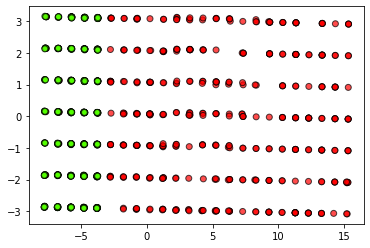

In [814]:
# Build and Plot PCA
from sklearn. model_selection import train_test_split 
from imblearn.under_sampling import RandomUnderSampler

df = generate_data(number_training_days = 100)
X,y = preprocess(df)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, shuffle=False)
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train.values, y_train)

pca = PCA(n_components=2)
pca.fit(X_res)
X_pca = pca.transform(X_res)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()
    

In [888]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

scores = ["precision", "recall"]

def tune_parameters(X_train,X_test,y_train,y_test, tuned_parameters, model):
    best_params = []
    best_classifiers = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        
        clf = GridSearchCV(model, tuned_parameters, scoring="%s_macro" % score)
        clf.fit(X_train, y_train)

        best_params.append(clf.best_params_)
        best_classifiers.append(clf.best_estimator_)
        print("Best parameters set found on development set:")
        print(clf.best_params_)
        print()
        '''print("Grid scores on development set:")
        print()
        means = clf.cv_results_["mean_test_score"]
        stds = clf.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()'''
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
    print(best_classifiers[0])
    print(best_classifiers[1])
    return best_params


In [885]:
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression

def predict(model, X_train, X_test, y_train, y_test, parameters):
    if model == 'dt':
        clf = tree.DecisionTreeClassifier()
    if model == 'svm':       
        clf = svm.SVC(**parameters)
    if model == 'lr':
        clf = LogisticRegression(random_state=0)
    clf.fit(X_train.values, y_train)
    return clf.predict(X_test.values)

In [886]:
from sklearn. model_selection import train_test_split
from sklearn.metrics import *

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def evaluate(model, parameters = None):
    for days in [3,7,14,18,30,60,90,180]:
        out = str(days) + ' days'
        for noise in [0.0,0.05,0.1,0.2,0.3]:
            avg_acc = []
            avg_f_score = []
            for i in range(100):
                y_train = np.zeros(1)
                y_test = np.zeros(1)
                while np.all((y_train == 0)) :#or np.all((y_test == 0)):
                    df = generate_data(number_training_days = days, noise = noise)
                    X,y = preprocess(df)
                    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

                dt_predicted = predict(model, X_train, X_test, y_train, y_test, parameters)

                avg_acc.append(accuracy_score(y_test, dt_predicted))
                avg_f_score.append(f1_score(y_test, dt_predicted))
                #print('Precision score %s' % precision_score(y_test, dt_predicted))
                #print('Recall score %s' % recall_score(y_test, dt_predicted))
                #print('F1-score score %s' % f1_score(y_test, dt_predicted))
                #print('Accuracy score %s' % accuracy_score(y_test, dt_predicted))
            avg_acc = int(100* round(sum(avg_acc) / len(avg_acc), 2))
            avg_f_score = int(100 * round(sum(avg_f_score) / len(avg_f_score),2))
            out += ' & \cfsc{'+str(avg_f_score) +'}'
        print(out+ ' \\\\ \hline' )


### Decision Tree Evaluation

In [873]:
evaluate(model = 'dt')

3 & \cfsc{89} & \cfsc{85} & \cfsc{81} & \cfsc{73} & \cfsc{61} \ \ \hline
7 & \cfsc{98} & \cfsc{92} & \cfsc{84} & \cfsc{75} & \cfsc{65} \ \ \hline
14 & \cfsc{99} & \cfsc{92} & \cfsc{88} & \cfsc{78} & \cfsc{66} \ \ \hline
18 & \cfsc{99} & \cfsc{95} & \cfsc{88} & \cfsc{79} & \cfsc{67} \ \ \hline
30 & \cfsc{100} & \cfsc{94} & \cfsc{89} & \cfsc{79} & \cfsc{69} \ \ \hline
60 & \cfsc{100} & \cfsc{94} & \cfsc{90} & \cfsc{80} & \cfsc{69} \ \ \hline
90 & \cfsc{100} & \cfsc{94} & \cfsc{89} & \cfsc{79} & \cfsc{70} \ \ \hline
180 & \cfsc{100} & \cfsc{95} & \cfsc{90} & \cfsc{80} & \cfsc{70} \ \ \hline


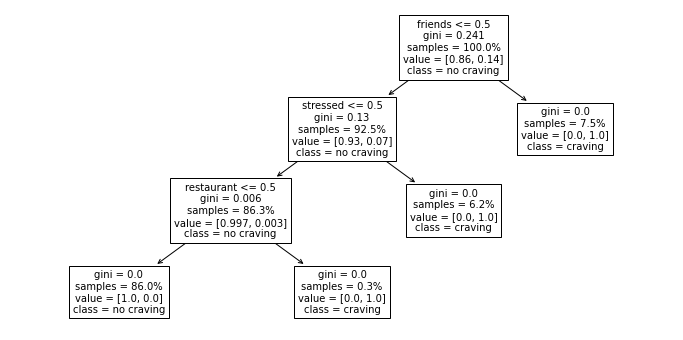

In [789]:
#plot example tree
df = generate_data(number_training_days = 30)
X,y = preprocess(df)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train.values, y_train)
plt.figure(figsize=(12,6)) 
tree.plot_tree(clf, fontsize=10, feature_names=X.columns, class_names=['no craving','craving'], proportion=True)

plt.savefig('tree_high_dpi', dpi=800, format = 'jpg')

### SVM Evaluation

In [851]:
tuned_parameters = [
            {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
            {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
        ]

for days in [10, 30, 60, 100]:
    print('-----------------------------------')
    print(days, "DAYS:")
    df = generate_data(number_training_days = days, noise = 0.2)
    X,y = preprocess(df)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    under_sampler = RandomUnderSampler(random_state=42)
    X_res, y_res = under_sampler.fit_resample(X_train.values, y_train)
    params = tune_parameters(X_train,X_test,y_train,y_test, tuned_parameters, model = svm.SVC())

-----------------------------------
10 DAYS:
# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        49
           1       0.82      0.64      0.72        14

    accuracy                           0.89        63
   macro avg       0.86      0.80      0.83        63
weighted avg       0.88      0.89      0.88        63

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0       0.90      0.96      0.93        49
           1       0.82      0.64      0.72        14

    accuracy                           0.89        63
   macro avg       0.86      0.80      0.83        63
weighted avg       0.88      0.89      0.88        63

SVC(C=1000, gamma=0.001)
SVC(C=1000, gam

In [877]:
best_params = {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
evaluate(model = 'svm', parameters = best_params)

3 days & \cfsc{73} & \cfsc{64} & \cfsc{69} & \cfsc{57} & \cfsc{49} \\ \hline
7 days & \cfsc{77} & \cfsc{82} & \cfsc{74} & \cfsc{64} & \cfsc{54} \\ \hline
14 days & \cfsc{84} & \cfsc{83} & \cfsc{78} & \cfsc{75} & \cfsc{59} \\ \hline
18 days & \cfsc{82} & \cfsc{79} & \cfsc{81} & \cfsc{77} & \cfsc{60} \\ \hline
30 days & \cfsc{88} & \cfsc{84} & \cfsc{84} & \cfsc{77} & \cfsc{65} \\ \hline
60 days & \cfsc{90} & \cfsc{88} & \cfsc{87} & \cfsc{77} & \cfsc{70} \\ \hline
90 days & \cfsc{90} & \cfsc{88} & \cfsc{83} & \cfsc{79} & \cfsc{68} \\ \hline
180 days & \cfsc{94} & \cfsc{88} & \cfsc{84} & \cfsc{83} & \cfsc{71} \\ \hline


### Logistic Regression

In [890]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [
            {"C": [1, 10, 100, 1000], "penalty":["l1","l2","elasticnet"]}
        ]

for days in [30, 60, 100, 1000]:
    print('-----------------------------------')
    print(days, "DAYS:")
    df = generate_data(number_training_days = days, noise = 0.2)
    X,y = preprocess(df)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
    under_sampler = RandomUnderSampler(random_state=42)
    X_res, y_res = under_sampler.fit_resample(X_train.values, y_train)
    params = tune_parameters(X_train,X_test,y_train,y_test, tuned_parameters, model = LogisticRegression())

-----------------------------------
30 DAYS:
# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'C': 1, 'penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       163
           1       0.70      0.95      0.81        20

    accuracy                           0.95       183
   macro avg       0.85      0.95      0.89       183
weighted avg       0.96      0.95      0.95       183

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 100, 'penalty': 'l2'}

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       163
           1       0.63      0.95      0.76        20

    accuracy                           0.93       183
   macro avg       0.81      0.94      0.86       183
weighted avg       0.95      0.93      0.94       183

LogisticRegression(C=1)
LogisticRegression(C=100)
--------------------------

In [891]:
best_params = {'C': 10}
evaluate(model = 'lr', parameters = best_params)

3 days & \cfsc{46} & \cfsc{45} & \cfsc{33} & \cfsc{35} & \cfsc{25} \\ \hline
7 days & \cfsc{71} & \cfsc{63} & \cfsc{60} & \cfsc{53} & \cfsc{47} \\ \hline
14 days & \cfsc{77} & \cfsc{71} & \cfsc{67} & \cfsc{60} & \cfsc{45} \\ \hline
18 days & \cfsc{77} & \cfsc{75} & \cfsc{64} & \cfsc{66} & \cfsc{52} \\ \hline
30 days & \cfsc{76} & \cfsc{75} & \cfsc{72} & \cfsc{62} & \cfsc{55} \\ \hline
60 days & \cfsc{81} & \cfsc{74} & \cfsc{71} & \cfsc{69} & \cfsc{59} \\ \hline
90 days & \cfsc{78} & \cfsc{77} & \cfsc{70} & \cfsc{65} & \cfsc{63} \\ \hline
180 days & \cfsc{81} & \cfsc{79} & \cfsc{73} & \cfsc{71} & \cfsc{60} \\ \hline


In [735]:
def build_and_test(model,X_tr, X_te, y_tr, y_te, y_score, threshold=False):
    
    y_score = model.predict_proba(X_te)
    fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
    roc_auc0 = auc(fpr0, tpr0)
    
    # Calculate the best threshold
    best_threshold = None
    if threshold:
        J = tpr0 - fpr0
        ix = argmax(J) # take the value which maximizes the J variable
        best_threshold = thresholds[ix]
        # adjust score according to threshold.
        y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])
        
    
    # Plot metrics 
    plot_roc(y_te, y_score)
    plt.show()
    
    plot_precision_recall(y_te, y_score)
    plt.show()
    
    plot_cumulative_gain(y_te, y_score)
    plt.show()
    
    plot_lift_curve(y_te, y_score)
    plt.show()
    return roc_auc0,fpr0,tpr0, best_threshold

roc_auc_imb,fpr_imb,tpr_imb, _ = build_and_test(model,X_res, X_test, y_res, y_test)